In [1]:
# 1 FILTER DATAFRAME USING THE SAME BOUNDING BOX YOU HAVE USED FOR QUERYING THE API
# 2 FETCH THE IMAGE IDS IN THE SAME BOUNDING BOX WITH MAPILLARY
# 3 MATCH THE IMAGE IDS WITH THE EDGE IDS:
#### - ADD EXTRA POINTS BETWEEN EVERY EDGE START AND END (edge points) 
#### - Construct A BALL TREE WITH THE EDGE POINTS (https://stackoverflow.com/questions/56862277/interpreting-sklearn-haversine-outputs-to-kilometers)
#### - Query the Ball tree using the simage points (for each image, find the closest point)
#### - Remove matches such that the distance is larger than 50 meters
#### - Build a dictionary image_id --> edge_id

In [2]:
import geopandas as gpd
import matplotlib.pylab as plt
from shapely.geometry import Polygon
import numpy as np
import itertools
from operator import itemgetter
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree
from shapely.geometry import Point, LineString
import requests as rq
import json
from sklearn.neighbors import BallTree
from dbfread import DBF

In [3]:
#Load shapefile

my_shapefile_path = "koebenhavn.shp"
my_shp = gpd.read_file(my_shapefile_path)
print(my_shp)

          edgeUID      osmId  \
0       174207903   33287608   
1       174208208   26606437   
2       174297915   33617063   
3       174315778  201761225   
4       174318013  204336817   
...           ...        ...   
301806  174470053  579058980   
301807  174490815  905243261   
301808  174475039  523529477   
301809  174498791  358311842   
301810  174486458  960137697   

                                                 geometry  
0       LINESTRING (12.21101 55.53315, 12.21102 55.53331)  
1       LINESTRING (12.21088 55.53637, 12.21084 55.53613)  
2       LINESTRING (12.12414 55.54850, 12.12640 55.54776)  
3       LINESTRING (12.19696 55.59202, 12.19650 55.59186)  
4       LINESTRING (12.22279 55.57121, 12.22276 55.57112)  
...                                                   ...  
301806  LINESTRING (12.56211 55.64295, 12.56211 55.642...  
301807  LINESTRING (12.56742 55.68013, 12.56750 55.68019)  
301808  LINESTRING (12.55413 55.66424, 12.55396 55.66422)  
301809  LINESTR

In [4]:
#Access to Mapillary API

clienttoken = "MLY|9628299323862586|367193f1276e3145e7872e973f7907f8"
#URL for getting only images within the chosen boundaries
url = f"https://graph.mapillary.com/images?access_token={clienttoken}&fields=id,computed_geometry&bbox=12.436781,55.545432,12.696969,55.731815"

response = rq.get(url)

rqcon = response.content

#Decode in order to get rid og bytestring 
deco = rqcon.decode()

result = json.loads(deco)
images = list(result.values())[0]

#Loop to get list of coordinates and ID's 
#Not all images has coordinates so the try/except only gets the ID's which has coordinates
coor = []
ID = []
for i in range(0,len(images)):
    try:
        coord = images[i]["computed_geometry"]["coordinates"]
        coor.append(coord)
        id = str(images[i]["id"])
        ID.append(id)
    except KeyError:
        continue
#print(coor[0][0])
#print(ID)
new_coor =[] 
for i in range(0,len(coor)):
    vupti = coor[i][0]




#Get coordinates as Shapely Points 
points = []

for i in range(0,len(coor)):
    point = Point(coor[i])
    points.append(point)

#print(points)

#Check if Id and points are the same length
#print(len(ID))
#print(len(points))


#Create geopandas dataframe from ID's and points
dataframepoints = {"ID": ID, "geometry": points}
df_points = gpd.GeoDataFrame(dataframepoints)
num_images = len(df_points)

print(df_points)


                    ID                   geometry
0     1252716841811412  POINT (12.53940 55.65890)
1     1446204756135452  POINT (12.51264 55.66090)
2     4144542052249862  POINT (12.45297 55.65790)
3     1359591687752440  POINT (12.45525 55.72573)
4     1373550560096386  POINT (12.60876 55.62318)
...                ...                        ...
1989  1443490489413506  POINT (12.60857 55.62319)
1990  1446275839045971  POINT (12.58341 55.60429)
1991  1991548784383671  POINT (12.59138 55.68560)
1992  2694775927497283  POINT (12.59414 55.69549)
1993  3983537755037204  POINT (12.44240 55.62087)

[1994 rows x 2 columns]


In [5]:
#Set boundaries
bound = Polygon([(12.436781, 55.545432), (12.436781, 55.731815), (12.696966, 55.731815), (12.696966, 55.545432)])

#Find the values from the shapefile that is within the boundaries
TF = my_shp.within(bound)


edges_within_bound_index = TF[TF].index

geo_tag = my_shp["geometry"][TF.values]


emp_list = []
for i in range(0,len(edges_within_bound_index)):
    segment_list = []
    for i in list(geo_tag.iloc[i].coords):
        segment_list.append(list(i))
    #if 2 < len(segment_list):
    #    continue
    emp_list.append(segment_list)



#Create dataframe 
data1 = {"ID": my_shp["edgeUID"][TF.values], "geometry": geo_tag}
df_lines = gpd.GeoDataFrame(data1)
print(df_lines)


#df_lines = gpd.GeoDataFrame(TF)



               ID                                           geometry
37      174444169  LINESTRING (12.44475 55.70224, 12.44475 55.702...
38      174446519  LINESTRING (12.46494 55.71004, 12.46464 55.710...
39      174452469  LINESTRING (12.64980 55.58916, 12.64970 55.58879)
40      174456116  LINESTRING (12.59565 55.62538, 12.59553 55.62537)
41      174456659  LINESTRING (12.60328 55.62767, 12.60316 55.62766)
...           ...                                                ...
301806  174470053  LINESTRING (12.56211 55.64295, 12.56211 55.642...
301807  174490815  LINESTRING (12.56742 55.68013, 12.56750 55.68019)
301808  174475039  LINESTRING (12.55413 55.66424, 12.55396 55.66422)
301809  174498791  LINESTRING (12.56624 55.71956, 12.56591 55.71970)
301810  174486458  LINESTRING (12.53238 55.68096, 12.53248 55.68096)

[101932 rows x 2 columns]


In [23]:
from shapely.geometry import Polygon, LineString

# Define the coordinates for the polygon
polygon_coords = [(12.436781, 55.545432), (12.436781, 55.731815), (12.696966, 55.731815), (12.696966, 55.545432)]

# Create the polygon
polygon = Polygon(polygon_coords)

# Define the number of rows and columns for the grid
num_rows = 2
num_cols = 2

# Calculate the step size for dividing the polygon
step_x = (polygon.bounds[2] - polygon.bounds[0]) / num_cols
step_y = (polygon.bounds[3] - polygon.bounds[1]) / num_rows

# Initialize a list to store the resulting squares
squares = []


# Iterate over the grid and split the polygon into squares
for i in range(num_rows):
    for j in range(num_cols):
        # Calculate the coordinates for each square
        square_coords = [
            (polygon.bounds[0] + j * step_x, polygon.bounds[1] + i * step_y),
            (polygon.bounds[0] + (j + 1) * step_x, polygon.bounds[1] + i * step_y),
            (polygon.bounds[0] + (j + 1) * step_x, polygon.bounds[1] + (i + 1) * step_y),
            (polygon.bounds[0] + j * step_x, polygon.bounds[1] + (i + 1) * step_y)
        ]
        # Create the square polygon
        
        # Add the square to the list
        squares.append(square_coords)

# Print the resulting squares
for square in squares:
    print(square)

[(12.436781, 55.545432), (12.5668735, 55.545432), (12.5668735, 55.638623499999994), (12.436781, 55.638623499999994)]
[(12.5668735, 55.545432), (12.696966, 55.545432), (12.696966, 55.638623499999994), (12.5668735, 55.638623499999994)]
[(12.436781, 55.638623499999994), (12.5668735, 55.638623499999994), (12.5668735, 55.731815), (12.436781, 55.731815)]
[(12.5668735, 55.638623499999994), (12.696966, 55.638623499999994), (12.696966, 55.731815), (12.5668735, 55.731815)]


In [24]:
coor = []
ID = []
for square in squares:
    url = f"https://graph.mapillary.com/images?access_token={clienttoken}&fields=id,computed_geometry&bbox={square[0][0]},{square[0][1]},{square[1][0]},{square[2][1]}"
    response = rq.get(url)
    rqcon = response.content
    #Decode in order to get rid og bytestring 
    deco = rqcon.decode()
    result = json.loads(deco)
    images = list(result.values())[0]
    #Loop to get list of coordinates and ID's 
    #Not all images has coordinates so the try/except only gets the ID's which has coordinates
    for i in range(0,len(images)):
        try:
            coord = images[i]["computed_geometry"]["coordinates"]
            coor.append(coord)
            id = str(images[i]["id"])
            ID.append(id)
        except KeyError:
            continue


points = []
for i in range(0,len(coor)):
    point = Point(coor[i])
    points.append(point)

    
dataframepoints = {"ID": ID, "geometry": points}
df_points = gpd.GeoDataFrame(dataframepoints)
num_images = len(df_points)

print(df_points)

                    ID                   geometry
0     1346886312341599  POINT (12.53390 55.62567)
1     1429729194073310  POINT (12.51842 55.61457)
2     1787035364824356  POINT (12.44756 55.61694)
3     1803229913220401  POINT (12.51643 55.61402)
4     3186839744927404  POINT (12.49488 55.61516)
...                ...                        ...
7953  1720058215018704  POINT (12.59798 55.70741)
7954  3082221948668317  POINT (12.57242 55.66853)
7955  1247569078991593  POINT (12.58584 55.67891)
7956  1617698148437349  POINT (12.62805 55.64709)
7957  1752120318522964  POINT (12.58701 55.71231)

[7958 rows x 2 columns]


<Axes: >

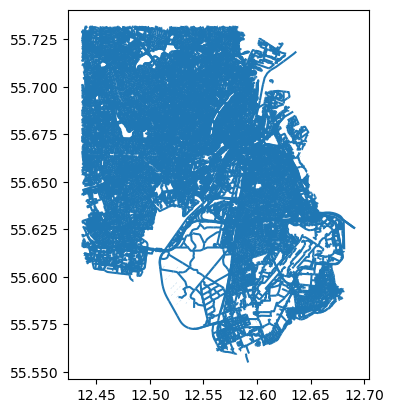

In [25]:

df_lines["geometry"].plot()

/tmp/ipykernel_227722/3281745053.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)   #With Buffer


<Axes: >

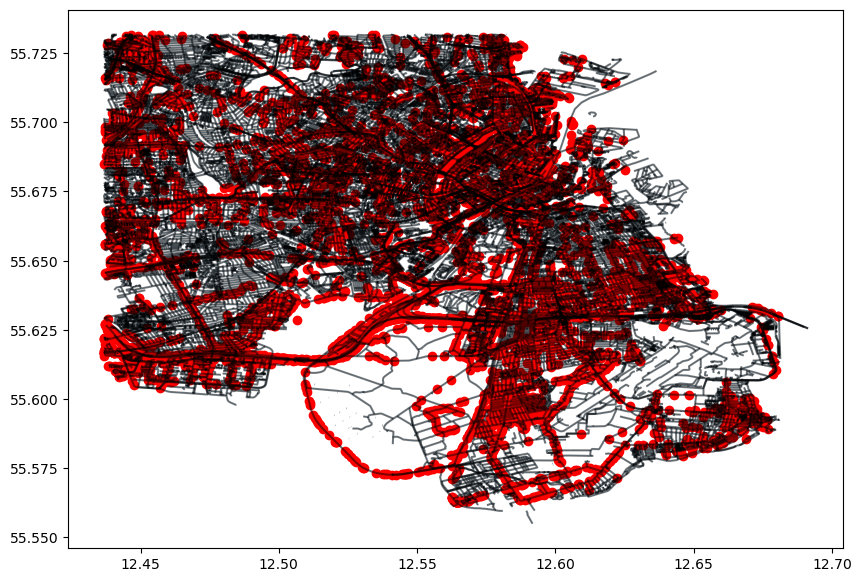

In [26]:
fig, ax = plt.subplots(figsize = (10,10))
df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)   #With Buffer
#df_lines["geometry"].plot(ax=ax,alpha=0.5)  #W/o buffer
df_lines["geometry"].plot(ax=ax,alpha=0.5,color = "k")
df_points["geometry"].plot(ax=ax,color = "r")



## Non-assigned Pictures

/tmp/ipykernel_227722/898194467.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001, cap_style = 2)
/tmp/ipykernel_227722/898194467.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)


548


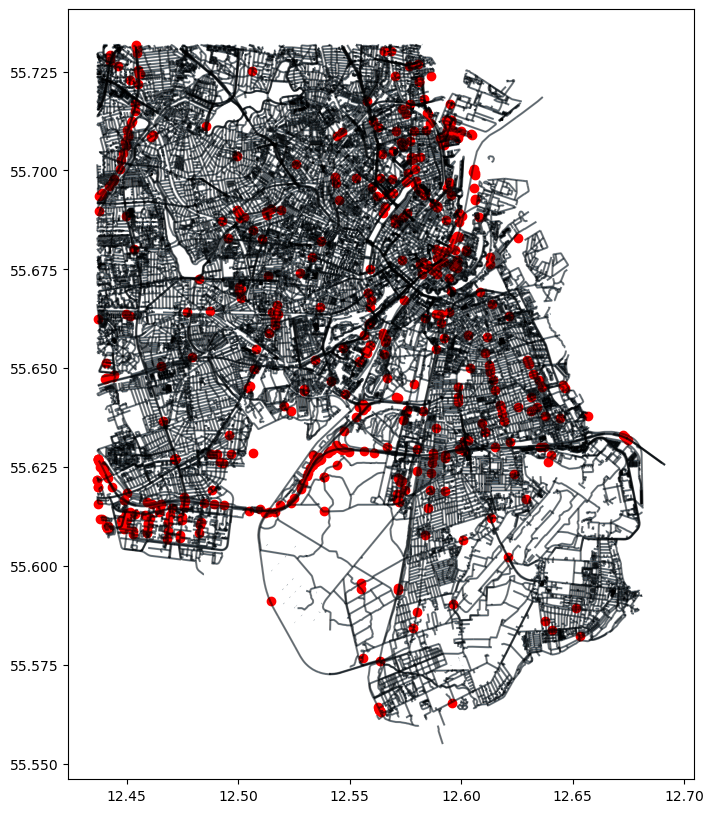

In [28]:
df_polygons = df_lines.copy()
df_polygons.crs = df_lines.crs
df_points.crs = df_lines.crs
df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001, cap_style = 2)

pointInPoly = gpd.sjoin(df_points, df_polygons, how='left',predicate='within') 

fig, ax = plt.subplots(figsize = (10,10))
df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)
df_lines["geometry"].plot(ax=ax,alpha=0.5,color = "k")
pointInPoly[pointInPoly['index_right'].isna()].plot(ax=ax,color = "r")

print(len(pointInPoly[pointInPoly['index_right'].isna()]))


In [29]:
pointInPoly

ID_left                   geometry  index_right     ID_right
0     1346886312341599  POINT (12.53390 55.62567)      41196.0  174450054.0
1     1429729194073310  POINT (12.51842 55.61457)       6500.0  174449858.0
2     1787035364824356  POINT (12.44756 55.61694)     182155.0  174399700.0
3     1803229913220401  POINT (12.51643 55.61402)     265980.0  174449972.0
4     3186839744927404  POINT (12.49488 55.61516)       1288.0  174448806.0
...                ...                        ...          ...          ...
7955  1247569078991593  POINT (12.58584 55.67891)     135848.0  174515538.0
7955  1247569078991593  POINT (12.58584 55.67891)     193176.0  174515532.0
7955  1247569078991593  POINT (12.58584 55.67891)     241372.0  174515534.0
7956  1617698148437349  POINT (12.62805 55.64709)     272585.0  174510257.0
7957  1752120318522964  POINT (12.58701 55.71231)      27815.0  174521570.0

[10594 rows x 4 columns]

<Axes: >

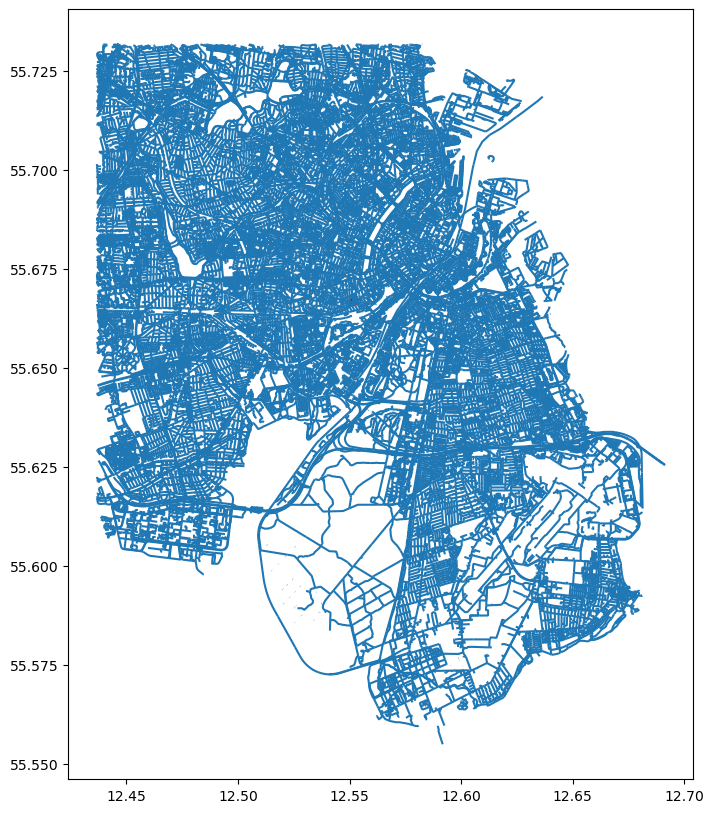

In [30]:
fig, ax = plt.subplots(figsize = (10,10))
test = pointInPoly[pointInPoly.ID_right==174475028].copy()
df_lines[df_lines.ID==174475028].plot(ax=ax, color = "k")
df_lines.plot(ax=ax)
test["geometry"].plot(color = "r",ax=ax)

(55.660144, 55.675971)

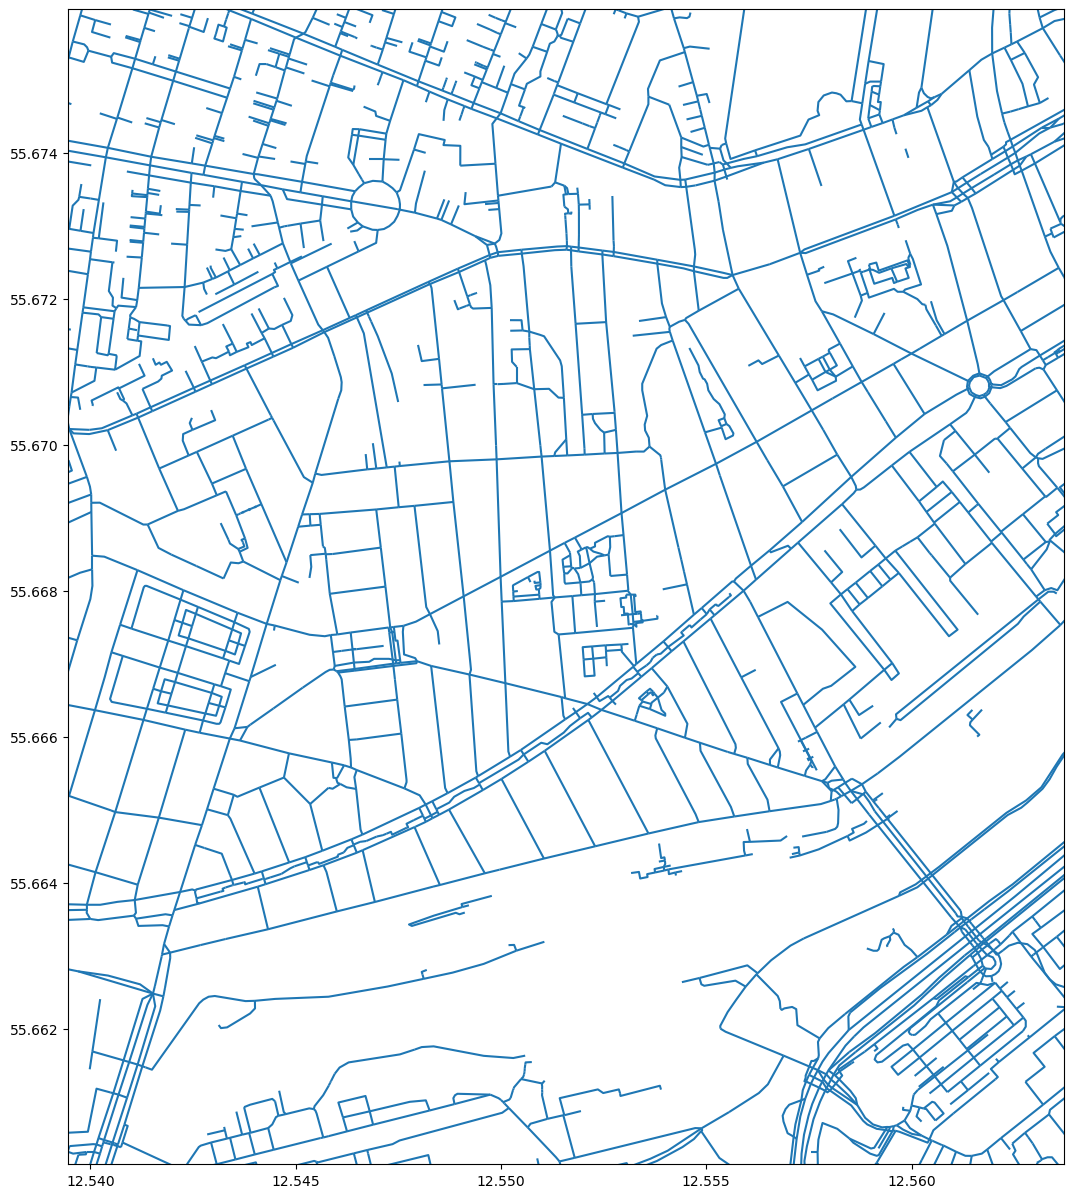

In [31]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))
my_shp.plot(ax = ax)

ax.set_xlim(12.539467, 12.563714)
ax.set_ylim(55.660144, 55.675971)

In [32]:
#Shapefile gives edgeUID, osmId and geometry 
shp = "/home/s214604/data_from_laura/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.shp"
strava_shape = gpd.read_file(shp)
#print(strava_shape)

#csv-file gives edge_uid, actitivity type, date, total_trip_count etc. 
strava_csv = pd.read_csv("/home/s214604/data_from_laura/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.csv")
#print(strava_csv)

#dbf-file gives edgeUID and osmId 
dbf = DBF('/home/s214604/data_from_laura/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.dbf')
frame = pd.DataFrame(iter(dbf))
#print(frame)

#textfile ???
file1 = open("/home/s214604/data_from_laura/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.txt","r")
#print(file1)

In [33]:

#print(strava_csv)

csv_df = {"ID": strava_csv["edge_uid"], "Activity": strava_csv["total_trip_count"]}
# "Month": strava_csv["month"]
csv_df = pd.DataFrame(data=csv_df)
csv_df = csv_df.dropna(subset=["ID"])
csv_df["Summed activity"] = csv_df.groupby("ID")["Activity"].transform("sum")
collapsed_df = csv_df.drop_duplicates(subset=["ID"], keep="first")
filtered_df = collapsed_df[collapsed_df["ID"].isin(df_lines["ID"])]

activity_df = pd.DataFrame({"ID": filtered_df["ID"], "Activity": filtered_df["Summed activity"]})

list_ID_ac = activity_df["ID"].tolist()
list_ID_line = df_lines["ID"].tolist()
print((len(list_ID_ac),len(list_ID_line)))

print(activity_df)


(69791, 101932)
                ID  Activity
88       174399891       155
168      174429188       670
180      174430746       290
192      174433856       630
207      174442329        30
...            ...       ...
1668874  174510955         5
1668875  174516758       245
1668887  174521793       305
1668958  174550725       815
1669106  174586129        50

[69791 rows x 2 columns]


In [34]:
merged_df = pd.merge(pointInPoly, activity_df, left_on="ID_right", right_on="ID")
merged_df

ID_left                   geometry  index_right     ID_right  \
0     1346886312341599  POINT (12.53390 55.62567)      41196.0  174450054.0   
1     1676415839385875  POINT (12.53378 55.62557)      41196.0  174450054.0   
2     1632014306985889  POINT (12.53879 55.62826)      41196.0  174450054.0   
3     4330897290288132  POINT (12.53762 55.62777)      41196.0  174450054.0   
4     1267089637019494  POINT (12.53368 55.62552)      41196.0  174450054.0   
...                ...                        ...          ...          ...   
9202  1682868115234546  POINT (12.56948 55.65747)     180725.0  174502187.0   
9203  1247569078991593  POINT (12.58584 55.67891)     135848.0  174515538.0   
9204  1247569078991593  POINT (12.58584 55.67891)     193176.0  174515532.0   
9205  1617698148437349  POINT (12.62805 55.64709)     272585.0  174510257.0   
9206  1752120318522964  POINT (12.58701 55.71231)      27815.0  174521570.0   

             ID  Activity  
0     174450054        10  
1     174450054        10  
2     174450054        10  
3     174450054        10  
4     174450054        10  
...         ...       ...  
9202  174502187      7930  
9203  174515538      1405  
9204  174515532       135  
9205  174510257      1485  
9206  174521570     11840  

[9207 rows x 6 columns]

In [35]:
isnull = merged_df.index[merged_df["Activity"].isnull()].tolist()

isnull

[]

In [36]:
'''
result = merged_df.drop_duplicates(['ID_left'],keep='first')
result
reset = result.reset_index()
reset.pop("index")
reset
#dataframe2 = reset.rename(columns = {"ID_left": "Image ID","geometry": "Image coordinate","index_right": "Segment index","ID_right": "Segment ID", "ID": "Segment ID","Activity": "Activity"}, inplace=True)
#print(dataframe2)
'''

'\nresult = merged_df.drop_duplicates([\'ID_left\'],keep=\'first\')\nresult\nreset = result.reset_index()\nreset.pop("index")\nreset\n#dataframe2 = reset.rename(columns = {"ID_left": "Image ID","geometry": "Image coordinate","index_right": "Segment index","ID_right": "Segment ID", "ID": "Segment ID","Activity": "Activity"}, inplace=True)\n#print(dataframe2)\n'

## Data Manipulation

In [37]:
list_image_id = pointInPoly["ID_left"].tolist()
list_image_id_new = list_image_id
list_image_id_new = [eval(i) for i in list_image_id_new]
list_image_id = [eval(i) for i in list_image_id]
#print(list_image_id_new)

clienttoken = "MLY|9628299323862586|367193f1276e3145e7872e973f7907f8"
#URL for getting only images within the chosen boundaries


ID_image = []
detection = []

ID_image = []
detection = []

for i in range(0,len(list_image_id_new)):
    url = f"https://graph.mapillary.com/{list_image_id_new[i]}/detections?access_token={clienttoken}&fields=image,value"
    response = rq.get(url)
    rqcon = response.content
    #Decode in order to get rid of bytestring 
    deco = rqcon.decode()
    result = json.loads(deco)
    images = list(result.values())[0]
    #print(len(images))
    #print(images)
    for i in range(0,len(images)):
        try:
            val = str(images[i]["value"])
            detection.append(val)
            ID = str(images[i]["image"]["id"])
            ID_image.append(ID)
        except KeyError:
            continue
            
#list of objects to remove 
vd = ["void--dynamic","void--static","void--unlabeled"]

indices_to_remove = [i for i, string in enumerate(detection) if string in vd]
new_string_list = []
new_index_list = []
for i in range(len(detection)):
    if i not in indices_to_remove:
        new_string_list.append(detection[i])
        new_index_list.append(ID_image[i])
    æ.



#print((len(new_index_list),len(new_string_list)))
dataframevalue = {"ID": new_index_list, "Detection": new_string_list}
df_imagess = gpd.GeoDataFrame(dataframevalue)
#print(df_imagess)
            
dict_image = df_imagess.groupby('ID')['Detection'].agg(list).to_dict()
#print(dict_image)
#print(dict_image)
dict_image2 = list(dict_image.values())
#print(dict_image2)
dict_image3 =sum(dict_image2, [])
#print(dict_image3)

def count_occurrence(lst):
    count = {}
    for item in lst:
        if item in count:
            count[item] += 1
        else:
            count[item] = 1
    return count

unique_occurrences = count_occurrence(dict_image3)

detections_per_image = []
dict_image_ids = []
image_ids = list(dict_image.keys())
for id in image_ids:
    dict_image_ids.append({'image_id': '{}'.format(id)})
    detections = count_occurrence(dict_image[id])
    detections_per_image.append(detections)
df_detections = pd.DataFrame.from_dict(detections_per_image)
df_image_ids = pd.DataFrame.from_dict(dict_image_ids)

#print(pd.DataFrame.from_dict(detections_per_image))
print(pd.DataFrame.from_dict(dict_image_ids))
print(pd.concat([df_image_ids,df_detections], axis = 1))

    

sorted_unique_occurrences = sorted(unique_occurrences.items(), key=lambda x:x[1])
#print(sorted_unique_occurrences)

              image_id
0     1229050897528283
1     1229072540842575
2     1229098270862569
3     1229113544171930
4     1229116290832976
...                ...
5411  8443327249014590
5412  8444276878916572
5413  8649155898491915
5414  9014381525303192
5415  9153172901420466

[5416 rows x 1 columns]
              image_id  regulatory--yield--g1  object--street-light  \
0     1229050897528283                    1.0                   1.0   
1     1229072540842575                    NaN                   1.0   
2     1229098270862569                    NaN                   4.0   
3     1229113544171930                    NaN                   5.0   
4     1229116290832976                    NaN                  12.0   
...                ...                    ...                   ...   
5411  8443327249014590                    NaN                   NaN   
5412  8444276878916572                    NaN                   NaN   
5413  8649155898491915                    NaN               

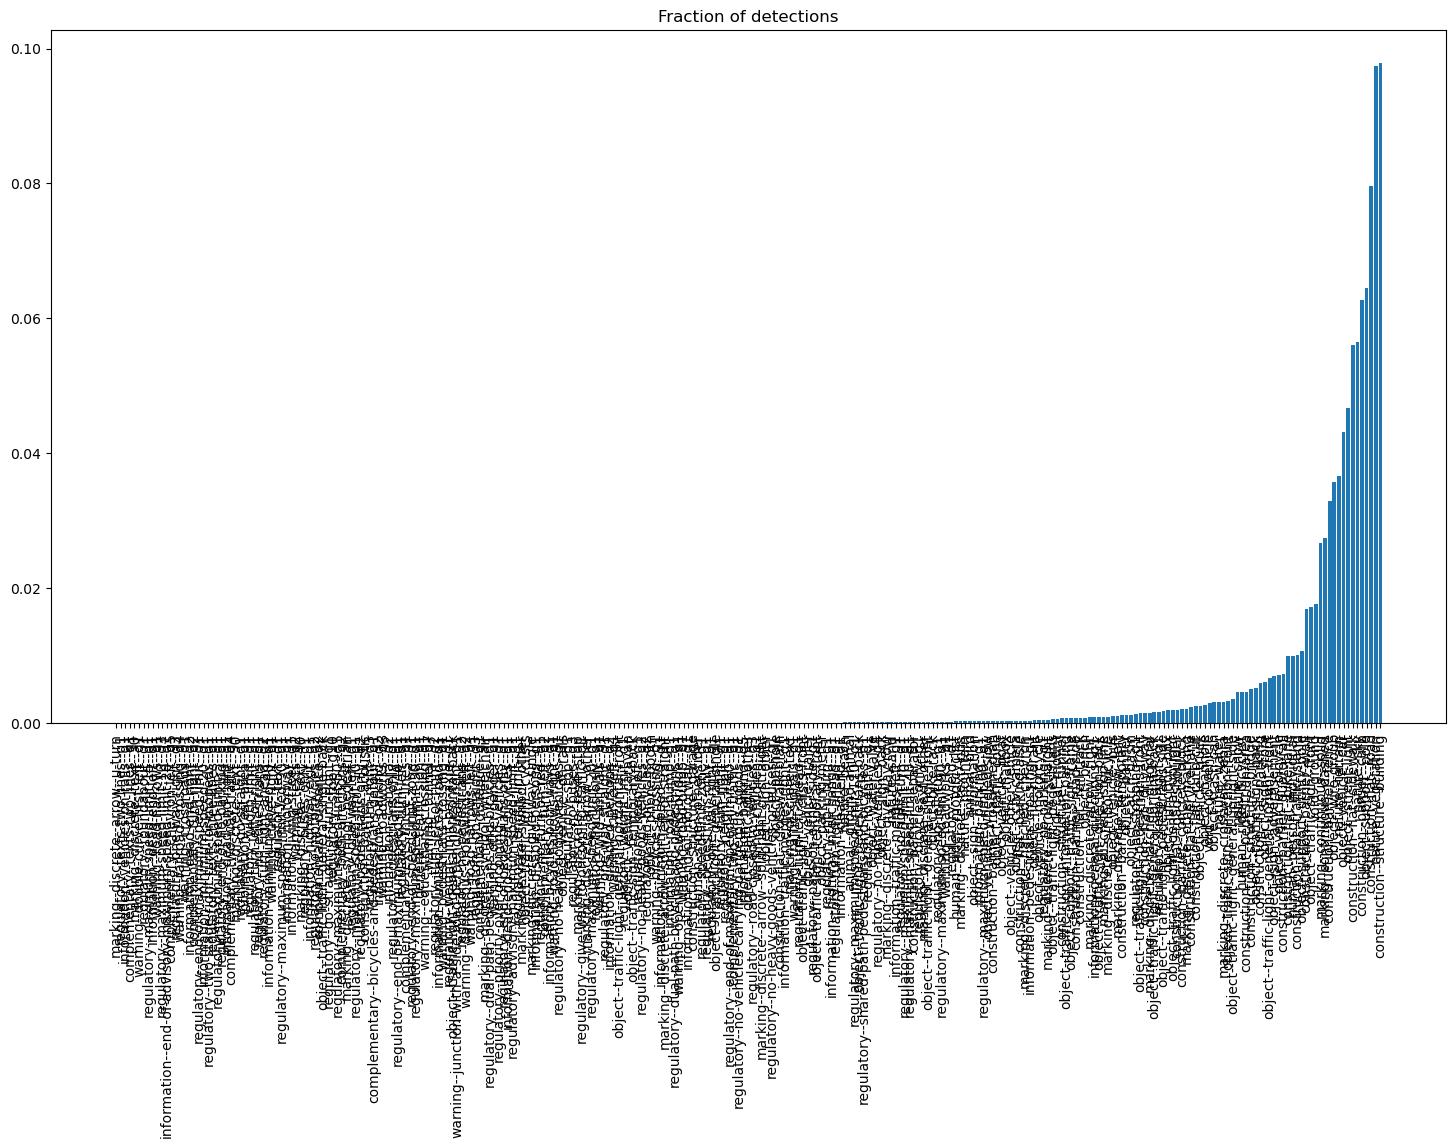

In [45]:
x_bar, y_bar = zip(*sorted_unique_occurrences)
y_bar = [x/sum(y_bar) for x in y_bar]
plt.figure(figsize=(18,9))
plt.bar(x_bar, y_bar)
plt.xticks(rotation = 90)
plt.title("Fraction of detections")
plt.show()

In [46]:

encounters = []
for keys in dict_image.keys():
    dab = count_occurrence(dict_image[keys])
    objects_found = list(dab.keys()) 
    encounters.append(objects_found)
encounters_tolist =  sum(encounters, [])
encounters_todict = count_occurrence(encounters_tolist)
sorted_unique_picture_encounters = sorted(encounters_todict.items(), key=lambda x:x[1])
    

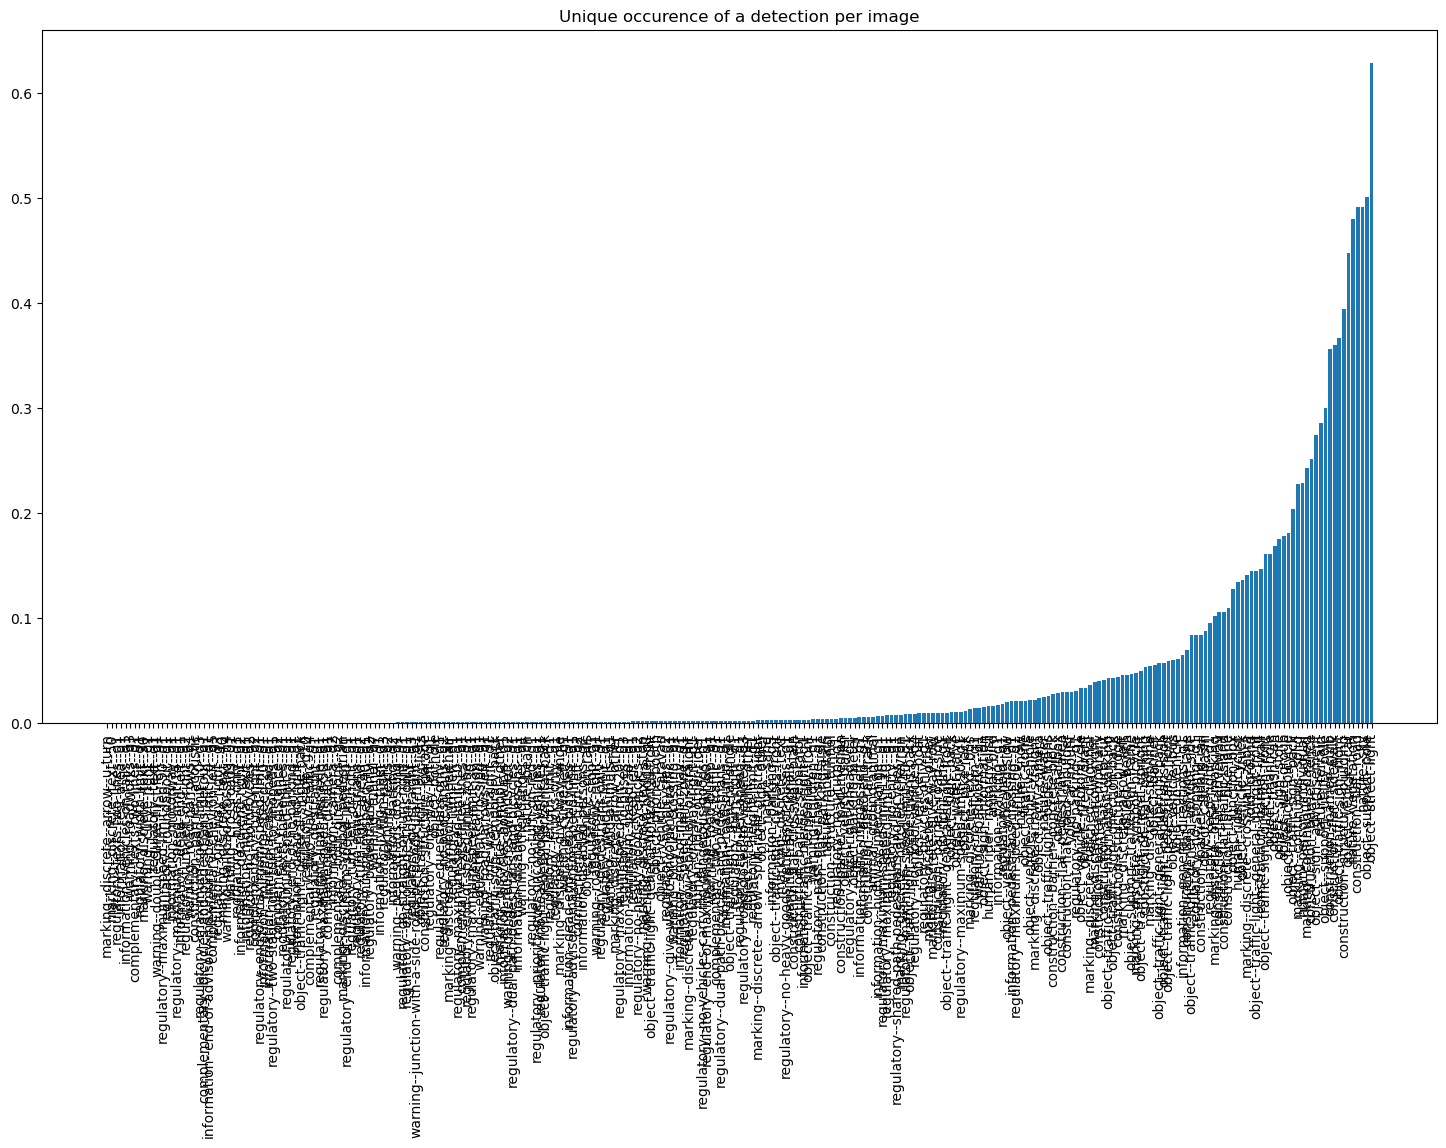

In [47]:
x_bar, y_bar = zip(*sorted_unique_picture_encounters)
y_bar = [x/len(dict_image) for x in y_bar]
plt.figure(figsize=(18,9))
plt.bar(x_bar, y_bar)
plt.xticks(rotation = 90)
plt.title("Unique occurence of a detection per image")
plt.show()

## Creating DataFrame with Data for Tree Model

In [48]:
#Loop over detections and create dictionaries, which can be manipulated for the creation of pd.dataframes

detections_per_image = []
dict_image_ids = []
image_ids = list(dict_image.keys())
for id in image_ids:
    dict_image_ids.append({'image_id': '{}'.format(id)})
    detections = count_occurrence(dict_image[id])
    detections_per_image.append(detections)

df_detections = pd.DataFrame.from_dict(detections_per_image)
df_image_ids = pd.DataFrame.from_dict(dict_image_ids)

#Concatenate the two dataframes containing detections per image and the image ID
image_detections = pd.concat([df_image_ids,df_detections], axis = 1)

#Assigning image ID's to edge ID's through pandas join functions
nonna_pointInPoly = pointInPoly.dropna()
df_image_edge = nonna_pointInPoly[["ID_left","ID_right"]]
df_image_edge = df_image_edge.rename(columns={'ID_left':'image_id', 'ID_right':'edge_id'})
merged_df = pd.merge(image_detections,df_image_edge, on = 'image_id')

#Lastly joining the activity from strava for the creation of the full dataset: |image_ids|detections|edge_id|#people|
df_activity = activity_df.rename(columns={'ID':'edge_id'})
data =  pd.merge(merged_df, df_activity, on='edge_id')

#Move edge_id column to location 0
edge_id_column = data.pop('edge_id')
data.insert(0, "edge_id", edge_id_column)
#Replace NaN with 0
data = data.fillna(0)

#Dataframe now looks like: |edge_id|image_ids|detections|#people|
print(data)

          edge_id          image_id  regulatory--yield--g1  \
0     174452649.0  1229050897528283                    1.0   
1     174467766.0  1229072540842575                    0.0   
2     174455027.0  1229098270862569                    0.0   
3     174455030.0  1229098270862569                    0.0   
4     174469219.0  1229116290832976                    0.0   
...           ...               ...                    ...   
6451  174503319.0  8287265144632017                    0.0   
6452  174516908.0  8444276878916572                    0.0   
6453  174516915.0  8444276878916572                    0.0   
6454  174503476.0  9014381525303192                    0.0   
6455  174503387.0  9153172901420466                    0.0   

      object--street-light  marking--discrete--text  \
0                      1.0                      0.0   
1                      1.0                      1.0   
2                      4.0                      0.0   
3                      4.0         

## Pop columns of detections that dont appear in atleast % of the pictures

                                       detection  occurence
29                   construction--flat--parking   0.053176
30                  marking--discrete--stop-line   0.054468
31                                object--banner   0.055576
32   object--traffic-light--general-upright-back   0.056684
33       object--traffic-light--pedestrians-side   0.057238
34      object--traffic-light--pedestrians-front   0.058715
35                          object--vehicle--bus   0.059638
36                             void--ego-vehicle   0.060931
37           information--general-directions--g1   0.065177
38              construction--flat--service-lane   0.069978
39   object--traffic-light--general-upright-side   0.083456
40                   regulatory--no-stopping--g1   0.083456
41             construction--barrier--guard-rail   0.083641
42                           object--catch-basin   0.087703
43                    regulatory--keep-right--g1   0.095089
44              marking--discrete--other

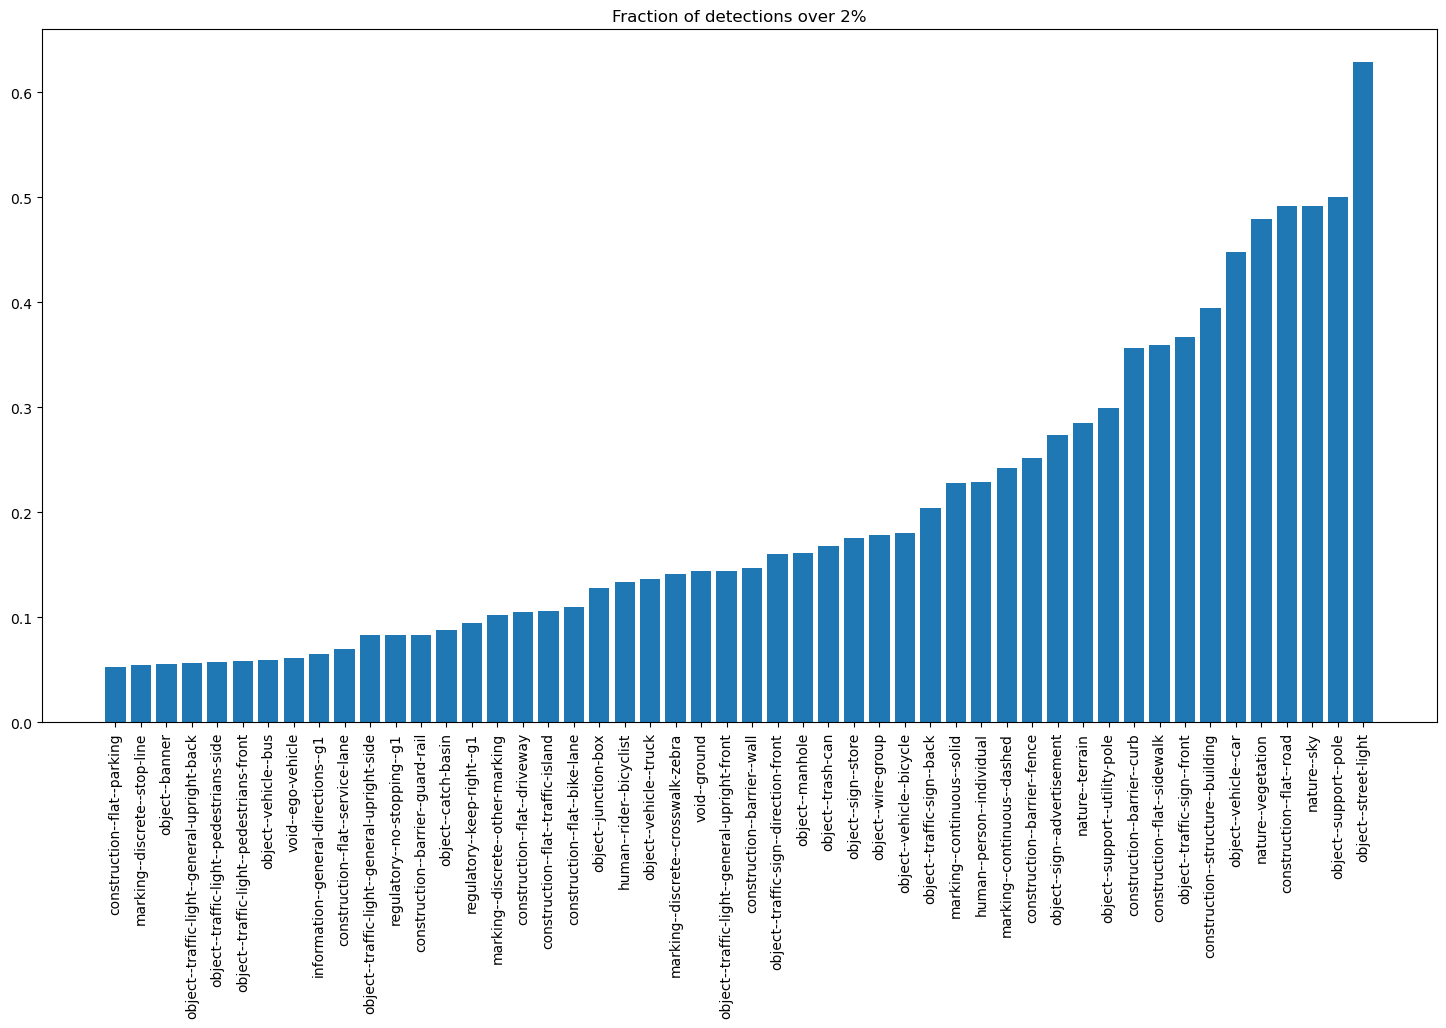

In [50]:
#Identify detections that are over 5%
df_unique_detections=pd.DataFrame(list(zip(x_bar,y_bar)),columns=['detection','occurence'])
df_unique_detections = df_unique_detections[df_unique_detections['occurence'] >= 0.05]
detections_of_interest = df_unique_detections['detection'].to_list()
#Now we have a list with the detections that we are interested in. We insert the coloumn names for edge ID, image ID 
#and activity to get that from our data dataframe
detections_of_interest.insert(0, 'edge_id')
detections_of_interest.insert(1, 'image_id')
detections_of_interest.append('Activity')
#Thus getting the desired columns for our data
data = data[detections_of_interest]

#Plot the new detections
x_bar, y_bar = df_unique_detections["detection"], df_unique_detections["occurence"]
print(df_unique_detections)
plt.figure(figsize=(18,9))
plt.bar(x_bar, y_bar)
plt.xticks(rotation = 90)
plt.title("Fraction of detections over 2%")
plt.show()

## Take average of detections for an specific edge

In [51]:
averaged_data = data
averaged_data = averaged_data.loc[:, averaged_data.columns != 'image_id']
averaged_data = averaged_data.loc[:, averaged_data.columns != 'Activity']
averaged_data=averaged_data.groupby('edge_id').mean().reset_index()
print(averaged_data)

          edge_id  construction--flat--parking  marking--discrete--stop-line  \
0     174398853.0                          0.0                           0.0   
1     174398882.0                          0.0                           0.0   
2     174398886.0                          0.0                           0.0   
3     174398887.0                          0.0                           0.0   
4     174398888.0                          0.0                           0.0   
...           ...                          ...                           ...   
4071  174772998.0                          0.0                           0.0   
4072  174773006.0                          0.0                           0.0   
4073  174773016.0                          0.0                           0.0   
4074  174773020.0                          0.0                           0.0   
4075  174773053.0                          0.0                           0.0   

      object--banner  object--traffic-l

## Joining everything together

In [52]:
data_without_image_ids = data.loc[:, data.columns != 'image_id']
data_with_average_detections = pd.merge(averaged_data, df_activity, on='edge_id')
print(data_with_average_detections)

          edge_id  construction--flat--parking  marking--discrete--stop-line  \
0     174398853.0                          0.0                           0.0   
1     174398882.0                          0.0                           0.0   
2     174398886.0                          0.0                           0.0   
3     174398887.0                          0.0                           0.0   
4     174398888.0                          0.0                           0.0   
...           ...                          ...                           ...   
4071  174772998.0                          0.0                           0.0   
4072  174773006.0                          0.0                           0.0   
4073  174773016.0                          0.0                           0.0   
4074  174773020.0                          0.0                           0.0   
4075  174773053.0                          0.0                           0.0   

      object--banner  object--traffic-l

edge_id|image_id|detections|#people (structure of the data)

Average detections per edge ID vs. Each image per edge ID. It could be better to look at the average, as a very long edge would result in diverse detections and be an outlier.